## Preparing the environment

In [1]:
import os
import random
import numpy as np

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, Dataset
import transformers
from accelerate import Accelerator

from tqdm import tqdm

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

data_path = "../data"
models_path = "../models"

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False

#### Setting constants

In [3]:
context_length = 128

batch_size = 128
num_workers = 8
global_batch_size = 512
accumulation_steps = global_batch_size // batch_size

learning_rate = 1e-3
betas = (0.9, 0.95)
eps = 1e-8
gradient_clipping = 1.0
weight_decay = 0.1

warmup_iters = 250

train_iters = 2000
eval_save_interval = 100
save_iters = [500, 1000]
val_iters = 20

model_name = "EleutherAI/pythia-70m"
model_revision = "step1000"

dataset_path = "allenai/c4"
dataset_name = "realnewslike"

## Loading dataset

In [4]:
dataset = load_dataset(dataset_path, dataset_name)
dataset = dataset.with_format("torch")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, revision=model_revision)

def tokenize(data):
    outputs = tokenizer(
        data["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = list()
    # deleting samples shorter than context_length tokens
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
if os.path.exists(os.path.join(data_path, "train_dataset")):
    train_dataset = Dataset.load_from_disk(os.path.join(data_path, "train_dataset"))
else:
    train_dataset = dataset["train"].map(
        tokenize, batched=True, remove_columns=dataset["train"].column_names
    )
    train_dataset.save_to_disk(os.path.join(data_path, "train_dataset"))


if os.path.exists(os.path.join(data_path, "val_dataset")):
    val_dataset = Dataset.load_from_disk(os.path.join(data_path, "val_dataset"))
else:
    val_dataset = dataset["validation"].map(
        tokenize, batched=True, remove_columns=dataset["validation"].column_names
    )
    val_dataset.save_to_disk(os.path.join(data_path, "val_dataset"))

Loading dataset from disk:   0%|          | 0/58 [00:00<?, ?it/s]

In [7]:
val_dataset = val_dataset.select(range(len(val_dataset) // (batch_size * val_iters) * (batch_size * val_iters)))

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Training

### Full-rank Training

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              worker_init_fn=seed_worker,
                              generator=g)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers,
                            worker_init_fn=seed_worker,
                            generator=g,
                            drop_last=True)

In [10]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name,
                                                          revision=model_revision,
                                                          attn_implementation="flash_attention_2").to(device)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)

scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_iters, num_training_steps=train_iters)

In [12]:
accelerator = Accelerator(mixed_precision="fp16")

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

In [13]:
def evaluate(model, val_dataloader, val_iters):
    model.eval()
    val_losses = list()
    for step, batch in enumerate(val_dataloader):
        with torch.inference_mode():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])
            val_losses.append(outputs.loss.item())
        if step + 1 >= val_iters:
            break
    val_loss = np.mean(val_losses)
    return val_loss

In [14]:
model.train()
train_losses = dict()
val_losses = dict()
last_losses = list()
completed_steps = 0

for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=int(train_iters * accumulation_steps)
    ):
    output = model(batch["input_ids"], labels=batch["input_ids"])
    loss = output.loss
    last_losses.append(loss.item())
    loss /= accumulation_steps
    accelerator.backward(loss)
    
    if step % accumulation_steps == 0:
        accelerator.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    
    if step % (eval_save_interval * accumulation_steps) == 0:
        train_losses[completed_steps] = np.mean(last_losses)
        val_losses[completed_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[completed_steps],
                "loss/val": val_losses[completed_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
        if completed_steps in save_iters:
            unwrapped_model = accelerator.unwrap_model(model)
            save_path = os.path.join(models_path, model_name.split('/')[-1] + f"_{completed_steps}_of_{train_iters}")
            unwrapped_model.save_pretrained(save_path, save_function=accelerator.save)

    if completed_steps >= train_iters:
        accelerator.wait_for_everyone()
        break

  5%|▌         | 400/8000 [01:26<1:31:34,  1.38it/s]

{'steps': 100, 'loss/train': 4.72970599770546, 'loss/val': 4.694854354858398}


 10%|█         | 800/8000 [02:50<1:24:24,  1.42it/s]

{'steps': 200, 'loss/train': 4.69335452914238, 'loss/val': 4.697908210754394}


 15%|█▌        | 1200/8000 [04:14<1:20:32,  1.41it/s]

{'steps': 300, 'loss/train': 4.68059521317482, 'loss/val': 4.655444526672364}


 20%|██        | 1600/8000 [05:37<1:23:48,  1.27it/s]

{'steps': 400, 'loss/train': 4.617198321819306, 'loss/val': 4.592515206336975}


 25%|██▍       | 1999/8000 [06:59<19:32,  5.12it/s]  

{'steps': 500, 'loss/train': 4.552124264240265, 'loss/val': 4.515317988395691}


 30%|███       | 2401/8000 [08:25<49:46,  1.87it/s]  

{'steps': 600, 'loss/train': 4.492244769334793, 'loss/val': 4.4743529796600345}


 35%|███▌      | 2800/8000 [09:49<1:01:52,  1.40it/s]

{'steps': 700, 'loss/train': 4.437030345201492, 'loss/val': 4.414971923828125}


 40%|████      | 3200/8000 [11:13<57:35,  1.39it/s]  

{'steps': 800, 'loss/train': 4.395024775266648, 'loss/val': 4.360307693481445}


 45%|████▌     | 3600/8000 [12:36<56:26,  1.30it/s]

{'steps': 900, 'loss/train': 4.349233882427216, 'loss/val': 4.33806688785553}


 50%|████▉     | 3999/8000 [13:58<12:52,  5.18it/s]

{'steps': 1000, 'loss/train': 4.311695774793625, 'loss/val': 4.292555856704712}


 55%|█████▌    | 4401/8000 [15:24<33:46,  1.78it/s]  

{'steps': 1100, 'loss/train': 4.279988496303559, 'loss/val': 4.2639693975448605}


 60%|██████    | 4801/8000 [16:49<30:04,  1.77it/s]

{'steps': 1200, 'loss/train': 4.244445304870606, 'loss/val': 4.231074810028076}


 65%|██████▌   | 5200/8000 [18:12<32:10,  1.45it/s]

{'steps': 1300, 'loss/train': 4.217515066862107, 'loss/val': 4.19982078075409}


 70%|███████   | 5600/8000 [19:36<32:23,  1.23it/s]

{'steps': 1400, 'loss/train': 4.180194089412689, 'loss/val': 4.166483402252197}


 75%|███████▌  | 6000/8000 [21:00<24:05,  1.38it/s]

{'steps': 1500, 'loss/train': 4.163447213768959, 'loss/val': 4.147358512878418}


 80%|████████  | 6400/8000 [22:24<19:41,  1.35it/s]

{'steps': 1600, 'loss/train': 4.141196060180664, 'loss/val': 4.120312166213989}


 85%|████████▌ | 6800/8000 [23:48<16:00,  1.25it/s]

{'steps': 1700, 'loss/train': 4.124134578108787, 'loss/val': 4.110553646087647}


 90%|█████████ | 7200/8000 [25:12<09:51,  1.35it/s]

{'steps': 1800, 'loss/train': 4.111041803359985, 'loss/val': 4.102173495292663}


 95%|█████████▌| 7600/8000 [26:36<04:59,  1.34it/s]

{'steps': 1900, 'loss/train': 4.103189907670021, 'loss/val': 4.117321634292603}


100%|█████████▉| 7999/8000 [28:00<00:00,  4.76it/s]

{'steps': 2000, 'loss/train': 4.103215230107307, 'loss/val': 4.092294192314148}


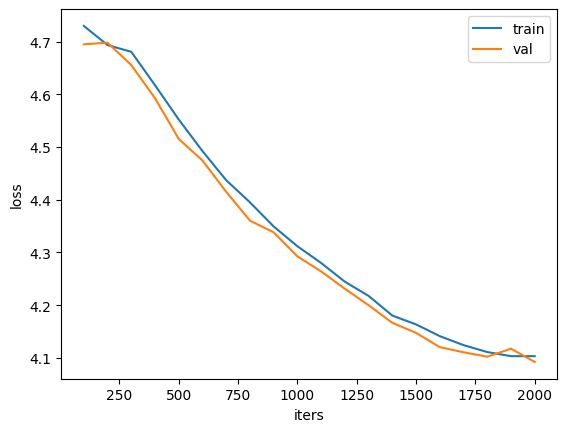

In [15]:
plt.plot(*zip(*train_losses.items()))
plt.plot(*zip(*val_losses.items()))
plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('iters')
plt.show()

In [16]:
import json

with open(os.path.join("../plots/", model_name.split('/')[-1] + "_train"), 'w') as fp:
    json.dump(train_losses, fp=fp)

with open(os.path.join("../plots/", model_name.split('/')[-1] + "_val"), 'w') as fp:
    json.dump(train_losses, fp=fp)